# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.6
IPython 7.2.0

numpy 1.16.1
scipy 1.2.1
pandas 0.24.1
matplotlib 3.0.2
statsmodels 0.9.0
sklearn 0.20.2

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 11, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : 16320c329a37d22cd546fef9b61479318f5485f7


In [5]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

In [6]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = r'C:\ds\geekhub-ds-2018\hw12\\'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [7]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [120]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [11]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [13]:
logreg = LogisticRegression(random_state=17, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

y_pred = logreg.predict(X_valid)
# logreg.predict_proba(X_valid)
score = logreg.score(X_valid, y_valid)
print(score)

# confusion_matrix = confusion_matrix(y_valid, y_pred)
# print(confusion_matrix)

0.7767243422611994


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [14]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1,cv=skf, multi_class='multinomial',
                                            random_state=17,n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)
logit_c_values1 = logit_grid_searcher1.Cs_

Wall time: 8.98 s


In [121]:
logit_c_values1

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [33]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1].mean(axis=0)
logit_mean_cv_scores1
# scores = cross_val_score(logit_grid_searcher1, X_valid, y_valid, cv=skf)
# scores

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.759199  , 0.75686451, 0.74975254, 0.7386779 ])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [56]:
import operator
index, value = max(enumerate(logit_mean_cv_scores1), key=operator.itemgetter(1))
print('max score =', value, '; C =', logit_c_values1[index])

max score = 0.7591990012394046 ; C = 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

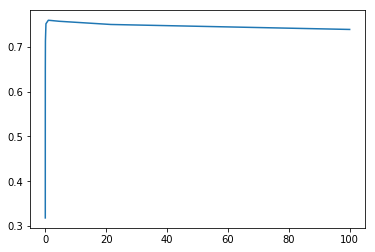

In [57]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [59]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', random_state=17,n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)
logit_c_values2 = logit_grid_searcher2.Cs_

Wall time: 24.5 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [62]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1].mean(axis=0)
logit_mean_cv_scores2

array([0.73684386, 0.75807821, 0.76102512, 0.76051677, 0.76000867,
       0.76041545, 0.76082146, 0.76031364, 0.75878931, 0.75848428,
       0.75797633, 0.7582818 , 0.75807882, 0.75777423, 0.75736754,
       0.75716422, 0.75675772, 0.75635165, 0.75635115, 0.75604655])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [67]:
index, value = max(enumerate(logit_mean_cv_scores2), key=operator.itemgetter(1))
log_reg2_max_c = logit_c_values2[index]
print('max score =', value, '; C =', log_reg2_max_c)

max score = 0.7610251150973616 ; C = 0.8263157894736842


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

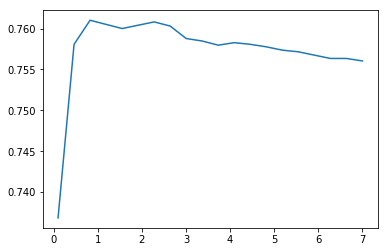

In [64]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [66]:
log_reg2_max_c = [log_reg2_max_c]
logit_grid_searcher2_maxC = LogisticRegressionCV(Cs=log_reg2_max_c, multi_class='multinomial', random_state=17,n_jobs=-1)
logit_grid_searcher2_maxC.fit(X_train, y_train)
y_pred = logit_grid_searcher2_maxC.predict(X_valid)
logit_cv_accur = accuracy_score(y_valid, y_pred)
logit_cv_accur

0.7755392273050485

**<font color='red'>Вопрос 1. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [70]:
c_v_s = cross_val_score(logit_grid_searcher2_maxC, X_valid, y_valid, scoring="accuracy", cv=skf, n_jobs=-1)

In [91]:
c_v_s = np.around(c_v_s, 3)
c_v_s

array([0.731, 0.71 , 0.731])

**2. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [95]:
from sklearn.svm import LinearSVC

In [123]:
svm = LinearSVC(C=1, random_state=17).fit(X_train, y_train)
y_pred = svm.predict(X_valid)
lin_cvs_acc = cross_val_score(svm, X_valid, y_valid, scoring="accuracy", cv=skf, n_jobs=-1)
lin_cvs_acc

array([0.71509568, 0.70177936, 0.72558803])

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [148]:
%%time
from sklearn import svm
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svc = svm.SVC()
svm_grid_searcher1 = GridSearchCV(svc, svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 3min 1s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [173]:
svm_best_c = svm_grid_searcher1.best_params_['C']

svm_grid_searcher_bestC = GridSearchCV(svc, {'C': [svm_best_c]})
svm_grid_searcher_bestC.fit(X_train, y_train)

print(svm_best_c)
accuracy_score(y_valid, svm_grid_searcher_bestC.predict(X_valid))

1111.1112


0.7646361697084617

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

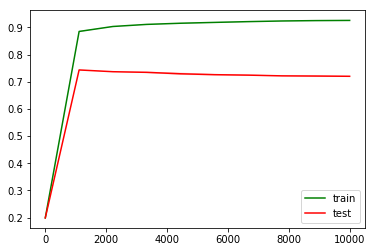

In [171]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [174]:
%%time
svc = svm.SVC()
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svc, svm_params2, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 3min 9s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [179]:
svm_c_v_s = cross_val_score(svm_grid_searcher2, X_valid, y_valid, scoring="accuracy", n_jobs=-1)
svm_c_v_s

array([0.30262225, 0.28754448, 0.29436921])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

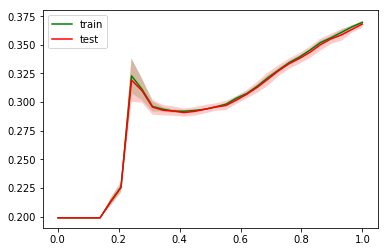

In [176]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [178]:
svm_best_c = svm_grid_searcher2.best_params_['C']

svm_grid_searcher_bestC = GridSearchCV(svc, {'C': [svm_best_c]})
svm_grid_searcher_bestC.fit(X_train, y_train)

svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher_bestC.predict(X_valid))
print(svm_best_c, svm_cv_acc)

1.0 0.40009480919649204


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [182]:
svm_c_v_s = cross_val_score(svm_grid_searcher_bestC, X_valid, y_valid, scoring="accuracy", n_jobs=-1)
svm_acc = accuracy_score(y_valid, svm_grid_searcher_bestC.predict(X_valid))
print(np.around(svm_c_v_s, 3), np.around(svm_acc, 3))

[0.303 0.283 0.294] 0.4


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [ ]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''

**Убедитесь, что функция работает.**

In [ ]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 3. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [ ]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [ ]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [ ]:
%%time
logit_cv_150users = LogisticRegressionCV ''' ВАШ КОД ЗДЕСЬ '''
logit_cv_150users.fit(X_train_150, y_train_150)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [ ]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format ''' ВАШ КОД ЗДЕСЬ '''

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [ ]:
class_distr = np.bincount(y_train_150.astype('int'))

for user_id in np.unique(y_train_150):
    ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 5. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**